In [49]:
import math
import numpy as np
import ceo
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [57]:
nLenslet = 30
n = 8
nPx = n*nLenslet+1
D = 25.5
n_radius = nPx
#onAxis = ceo.Source("R",zenith=0.*math.pi/180/3600,azimuth=0*math.pi/4,
#                    rays_box_size=D,rays_box_sampling=nPx,rays_origin=[0.0,0.0,-25])
src    = ceo.Source("R",zenith=5*60*math.pi/180/3600,azimuth=0*math.pi/4,
                    rays_box_size=D,rays_box_sampling=nPx,rays_origin=[0.0,0.0,25])
M1 = ceo.GMT_M1(D,nPx,radial_order = 10)
M2 = ceo.GMT_M2(D,nPx,radial_order = 10)

In [58]:
def optical_system(x,_src_,radius):
    _src_.reset()
    _src_.stop(M2)
    _src_.trace(M1)
    _src_.trace(M2)
    #rays.to_z_plane(5.83001949259)
    _src_.rays.to_sphere(radius,sphere_distance=x)
    _src_.opd2phase();
def opd_res_fun(x,radius):
    optical_system(x,src,radius)
    return src.wavefront.rms()*1e9

In [59]:
from scipy.optimize import minimize_scalar
#print opd_fun(5.83001949259)
sphere_radius = 1
#res = minimize_scalar(opd_fun, bounds=(26.09249-b,26.09249+b), method='bounded')
res = minimize_scalar(opd_res_fun, bounds=(25.5,26.5), method='bounded',args=(sphere_radius,))
print res.success
print res.x
chief_xyz = src.rays.chief_coordinates.host() - sphere_radius*src.rays.chief_directions.host()
print chief_xyz.shape
print "Minimum wfe rms focus @ [%6.4f,%6.4f,%6.4f]m with rms wfe=%6.4fnm"%(chief_xyz[0,0],chief_xyz[0,1],chief_xyz[0,2],opd_res_fun(res.x,sphere_radius))

True
[ 26.11544991]
(1, 3)
Minimum wfe rms focus @ [-0.3022,-0.0000,-5.8510]m with rms wfe=1278.5072nm


In [60]:
n = nPx
R = D/2
u = np.linspace(-1,1,n)*R
x,y = np.meshgrid(u,u)
xy = np.array( [ x.flatten(), y.flatten()] )

In [72]:
def ROT(o):
    return np.array([ [ math.cos(o), math.sin(o)], [-math.sin(o),math.cos(o)] ])
rc = 4.387
xy_rc = np.array([[0],[rc]])
print xy_rc
rp = 7.543
xy_rp = np.array([[rp],[0]])
print xy_rp
W = 1.5
L = 1.5
xySrc = 82.5*np.array( [[src.zenith*math.cos(src.azimuth)],[src.zenith*math.sin(src.azimuth)]] )
print xySrc

[[ 0.   ]
 [ 4.387]]
[[ 7.543]
 [ 0.   ]]
[[ 0.11999138]
 [ 0.        ]]


In [76]:
M = []
for k in range(6):
    theta = -k*math.pi/3
    #print ROT(theta)
    xyp = np.dot(ROT(theta),xy) - xy_rc - xySrc
    M.append( np.logical_and( np.abs(xyp[0,:])<L/2,  np.abs(xyp[1,:])<W/2 ) )
for k in range(6):
    theta = (1-k)*math.pi/3
    #print ROT(theta)
    xyp = np.dot(ROT(theta),xy) - xy_rp - xySrc
    M.append( np.logical_and( np.abs(xyp[0,:])<L/2,  np.abs(xyp[1,:])<W/2 ) )
M = np.array( M )
print M.shape

(12, 58081)


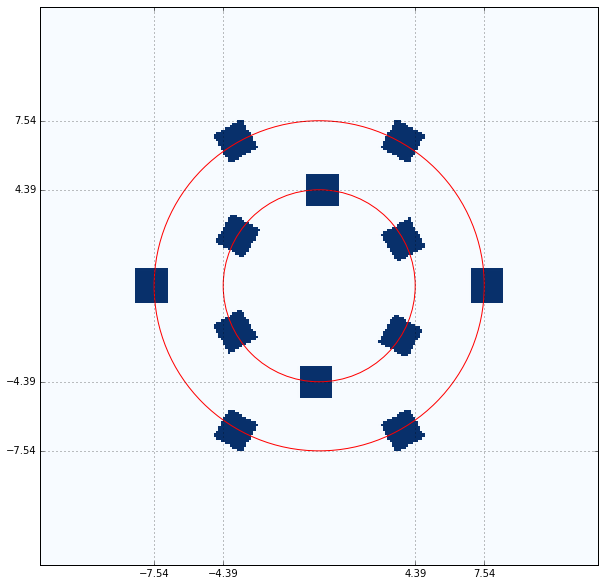

In [77]:
fig,ax =subplots()
fig.set_size_inches((10,10))
ax.imshow(M.sum(axis=0).reshape((n,n)),extent=[-R,R,-R,R],interpolation='None',cmap='Blues',origin='lower')
#ax.imshow(M[7,:].reshape((n,n)),extent=[-R,R,-R,R],interpolation='None',cmap='Blues',origin='lower')
grid()
xticks([-rp,-rc,rc,rp])
yticks([-rp,-rc,rc,rp])
c1 = Circle((0,0),radius=rc, color='r', fill=False)
ax.add_patch(c1)
c2 = Circle((0,0),radius=rp, color='r', fill=False)
ax.add_patch(c2)

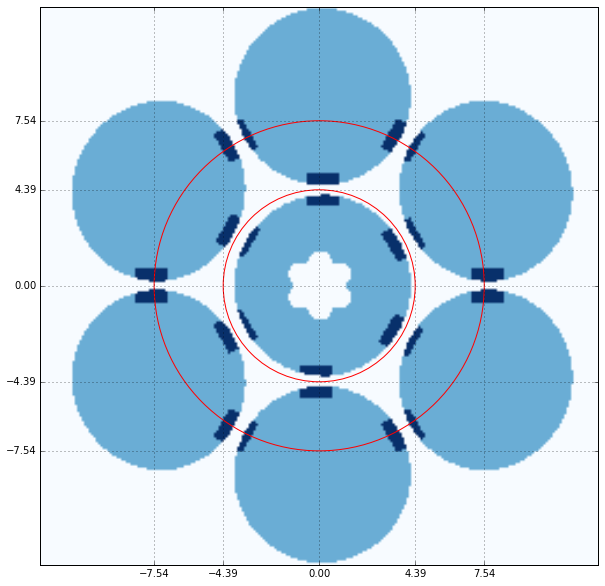

In [78]:
fig,ax =subplots()
fig.set_size_inches((10,10))
P = M1.piston_mask.sum(axis=0)
P = src.wavefront.amplitude.host().flatten()
ax.imshow(P.reshape(nPx,nPx) + np.logical_and(P,M.sum(axis=0)).reshape(nPx,nPx),
          extent=[-R,R,-R,R],interpolation=None,cmap='Blues',origin='lower')
grid()
xticks([-rp,-rc,0,rc,rp])
yticks([-rp,-rc,0,rc,rp])
c1 = Circle((0,0),radius=rc, color='r', fill=False)
ax.add_patch(c1)
c2 = Circle((0,0),radius=rp, color='r', fill=False)
ax.add_patch(c2)

In [10]:
src.wavefront.piston(mask=M1.piston_mask)*1e9

array([ 3.65800071,  3.6561923 ,  3.65617752,  3.65799379,  3.65619373,
        3.65617371,  1.44682479], dtype=float32)

In [11]:
P = M1.piston_mask
P.shape

(7, 58081)

In [12]:
P[1,:].shape

(58081,)

In [13]:
M.shape

(12, 58081)

In [14]:
W = (P * np.array([arange(1,8)]).T**2).sum(axis=0)

<matplotlib.colorbar.Colorbar instance at 0x2b3dc6a6d8c0>

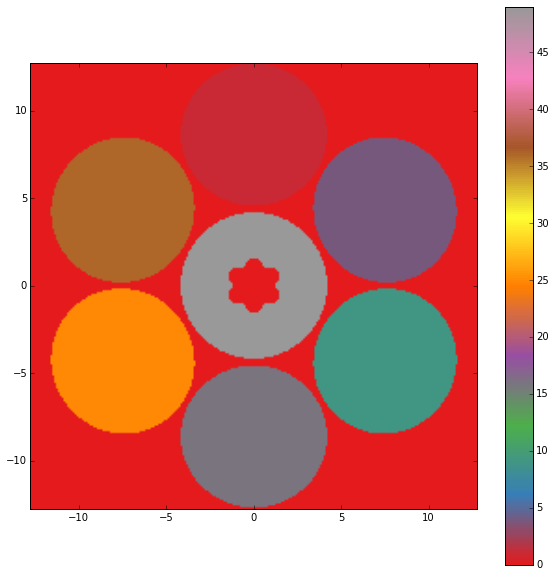

In [24]:
fig, ax =subplots()
fig.set_size_inches((10,10))
h = ax.imshow(W.reshape(nPx,nPx),extent=[-R,R,-R,R],interpolation=None,cmap='Set1',origin='lower')
colorbar(h)

<matplotlib.colorbar.Colorbar instance at 0x2b3dc66c5a28>

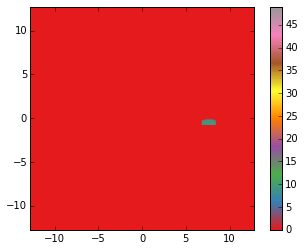

In [16]:
imshow((W*P[2,:]*M[7,:]).reshape(nPx,nPx),
       extent=[-R,R,-R,R],interpolation=None,cmap='Set1',clim=[0,49],origin='lower')
colorbar()

In [17]:
(W*P[0,:]*M[0,:]).shape

(58081,)

In [18]:
(W*P[6,:]*M[0,:]).T.shape

(58081,)

In [19]:
print np.sum( W*P[0,:]*M[0,:] )/np.sum( P[0,:]*M[0,:] ) - np.sum( W*P[6,:]*M[0,:] )/np.sum( P[6,:]*M[0,:] )
print np.sum( W*P[0,:]*M[6,:] )/np.sum( P[0,:]*M[6,:] ) - np.sum( W*P[1,:]*M[6,:] )/np.sum( P[1,:]*M[6,:] )

-48
-3


In [20]:
print np.sum( W*P[1,:]*M[1,:] )/np.sum( P[1,:]*M[1,:] ) - np.sum( W*P[6,:]*M[1,:] )/np.sum( P[6,:]*M[1,:] )
print np.sum( W*P[1,:]*M[6,:] )/np.sum( P[1,:]*M[6,:] ) - np.sum( W*P[2,:]*M[7,:] )/np.sum( P[2,:]*M[7,:] )

-45
-5


In [41]:
for k in range(6):
    print k,(k+1)%6
    print np.sum( W*P[k,:]*M[k,:] )/np.sum( P[k,:]*M[k,:] ) - \
        np.sum( W*P[6,:]*M[k,:] )/np.sum( P[6,:]*M[k,:] )
    print np.sum( W*P[k,:]*M[k+6,:] )/np.sum( P[k,:]*M[k+6,:] ) - \
        np.sum( W*P[(k+1)%6,:]*M[k+6,:] )/np.sum( P[(k+1)%6,:]*M[k+6,:] )

0 1
-48
-3
1 2
-45
-5
2 3
-40
-7
3 4
-33
-9
4 5
-24
-11
5 0
-13
35


In [48]:
print range(7)
print np.roll(np.array(range(7)),1)

[0, 1, 2, 3, 4, 5, 6]
[6 0 1 2 3 4 5]


In [46]:
for k in range(6):
    print np.sum( W*P[k,:]*M[k,:] )/np.sum( P[k,:]*M[k,:] ) - \
        np.sum( W*P[6,:]*M[k,:] )/np.sum( P[6,:]*M[k,:] )
    print np.sum( W*P[k,:]*M[k+6,:] )/np.sum( P[k,:]*M[k+6,:] ) - \
        np.sum( W*np.roll(P,-2,axis=0)[k,:]*M[k+6,:] )/np.sum( np.roll(P,-2,axis=0)[k,:]*M[k+6,:] )

-48
1
-45
4
-40
9
-33
16
-24
25
-13
35


/home/ubuntu/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: RuntimeWarning: divide by zero encountered in long_scalars
  app.launch_new_instance()


In [59]:
k = 5

In [62]:
np.sum( W*P[0,:]*M[11,:] )/np.sum( P[0,:]*M[k+6,:] )

1

In [34]:
np.sum( P[0,:]*M[11,:] )

74

In [45]:
np.sum( np.roll(P,-2,axis=0)[5,:]*M[11,:] )

74

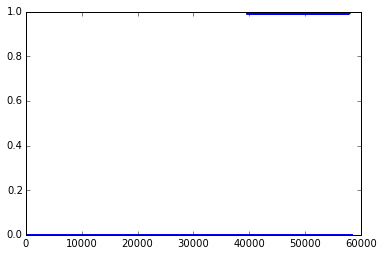

In [39]:
plot(P[0,:],'.')
plot(np.roll(P,1,axis=0)[5,:])

In [40]:
P.shape

(7, 58081)

In [26]:
print a[0:15]

[0 1 2 3 4 5 6 7 8 9]


In [50]:
a = np.random.normal(size=(4,3))
print a

[[ 0.21644577  1.07402092  0.35452362]
 [ 1.25122695  0.23765818 -1.25752856]
 [-0.09828109 -0.30587802 -0.78695892]
 [-0.85557025  0.37966756  0.19484061]]


In [56]:
print roll(a,-1,axis=0)

[[ 1.25122695  0.23765818 -1.25752856]
 [-0.09828109 -0.30587802 -0.78695892]
 [-0.85557025  0.37966756  0.19484061]
 [ 0.21644577  1.07402092  0.35452362]]


In [ ]:
P.shape

In [ ]:
print P